# Wavenet

Encoder Decoder LSTM With logcosh

In [37]:
# Autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
# Imports
import numpy as np
import json
import pandas as pd
import numpy as np
import time
import string
from matplotlib import pyplot as plt
import tensorflow as tf
import sys
sys.path.append('../../../')
from brain2brain import utils, generators, models
%matplotlib inline

# TF
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# TCN
from brain2brain.tcn import TCN
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Flatten, GRU, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.models import model_from_json


from scipy.stats import pearsonr

In [39]:
train_paths = utils.get_file_paths("/home/tmarcu/brain2brain/brain2brain/train_676_bin_norm_2.txt")
val_paths = utils.get_file_paths("/home/tmarcu/brain2brain/brain2brain/val_676_bin_norm_2.txt")
total_electrode_count = utils.get_file_shape(train_paths[0])[1]
# Electrodes
electrode_count = 114
electrodes = range(114)
electrode = 5
lookback = 100
pred_length = 20
# Training Generator
train_generator = generators.FGenerator(file_paths=train_paths,
                                        lookback=lookback,
                                        length=pred_length,
                                        delay=0,
                                        batch_size=1024,
                                        sample_period=1,
                                        electrodes=electrodes,
                                        electrode_output_ix=electrode,
                                        shuffle=True,
                                        teacher_forcing=True,
                                        teacher_forcing_concat=True)
# Validation Generator
val_generator = generators.FGenerator(file_paths=val_paths,
                                        lookback=lookback,
                                        length=pred_length,
                                        delay=0,
                                        batch_size=1024,
                                        sample_period=1,
                                        electrodes=electrodes,
                                        electrode_output_ix=electrode,
                                        shuffle=False,
                                        teacher_forcing=True,
                                        teacher_forcing_concat=True)

(5429, 114)


In [40]:
train_generator[0][0].shape
train_generator[0][1].shape

(1024, 20, 1)

In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Dense, Activation, Dropout, Lambda, Multiply, Add, Concatenate
from tensorflow.keras.optimizers import Adam

# convolutional operation parameters
n_filters = 32 # 32 
filter_width = 2
dilation_rates = [2**i for i in range(8)] * 2 
print(dilation_rates)
# define an input history series and pass it through a stack of dilated causal convolution blocks. 
history_seq = Input(shape=(None, electrode_count))
x = history_seq

skips = []
for dilation_rate in dilation_rates:
    
    # preprocessing - equivalent to time-distributed dense
    x = Conv1D(16, 1, padding='same', activation='relu')(x) 
    
    # filter convolution
    x_f = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # gating convolution
    x_g = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # multiply filter and gating branches
    z = Multiply()([Activation('tanh')(x_f),
                    Activation('sigmoid')(x_g)])
    
    # postprocessing - equivalent to time-distributed dense
    z = Conv1D(16, 1, padding='same', activation='relu')(z)
    
    # residual connection
    x = Add()([x, z])    
    
    # collect skip connections
    skips.append(z)

# add all skip connection outputs 
out = Activation('relu')(Add()(skips))

# final time-distributed dense layers 
out = Conv1D(128, 1, padding='same')(out)
out = Activation('relu')(out)
out = Dropout(.2)(out)
out = Conv1D(1, 1, padding='same')(out)

# extract the last 60 time steps as the training target
def slice(x, seq_length):
    return x[:,-seq_length:,:]

pred_seq_train = Lambda(slice, arguments={'seq_length':20})(out)

model = Model(history_seq, pred_seq_train)
model.compile(Adam(), loss='mean_absolute_error')

[1, 2, 4, 8, 16, 32, 64, 128, 1, 2, 4, 8, 16, 32, 64, 128]


NameError: name 'electrode_count' is not defined

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 114)]  0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, None, 16)     1840        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, None, 32)     1056        conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, None, 32)     1056        conv1d[0][0]                     
______________________________________________________________________________________________

In [11]:
callback_list = [
#         EarlyStopping(
#             monitor="val_loss",
#             patience=2,
#             mode="min"
#         )
]
history = model.fit_generator(generator=train_generator,
                              callbacks=callback_list,
                              epochs=100,
                              validation_data=val_generator)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 12 steps, validate for 4 steps
Epoch 1/100
12/12 [==============================] - 21s 2s/step - loss: 0.7392 - val_loss: 0.6940
Epoch 2/100
12/12 [==============================] - 11s 941ms/step - loss: 0.6888 - val_loss: 0.6503
Epoch 3/100
12/12 [==============================] - 11s 946ms/step - loss: 0.6495 - val_loss: 0.6102
Epoch 4/100
12/12 [==============================] - 11s 951ms/step - loss: 0.6087 - val_loss: 0.5773
Epoch 5/100
12/12 [==============================] - 11s 943ms/step - loss: 0.5836 - val_loss: 0.5600
Epoch 6/100
12/12 [==============================] - 12s 959ms/step - loss: 0.5697 - val_loss: 0.5498
Epoch 7/100
12/12 [==============================] - 11s 941ms/step - loss: 0.5590 - val_loss: 0.5417
Epoch 8/100
12/12 [==============================] - 11s 950ms/step - loss: 0.5498 - val_loss: 0.5337
Epoch 9/100
12/12 [==============================] - 11s 939ms/step - loss: 0.5424 - val_loss: 0

In [10]:
# serialize model to JSON
model_json = model.to_json()
with open(f"{file_name}.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights(f"{file_name}.h5")


NameError: name 'model' is not defined

In [41]:
file_name = "models/wavenet_m2o_model"
# load json and create model
json_file = open(f'{file_name}.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights(f"{file_name}.h5")
print("Loaded model from disk")

Loaded model from disk


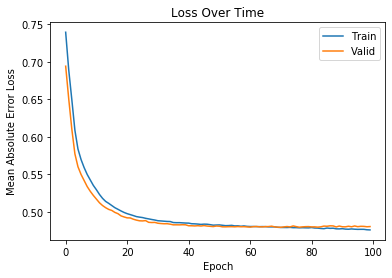

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [42]:
inf_generator = generators.FGenerator(file_paths=val_paths,
                                        lookback=lookback,
                                        length=pred_length,
                                        delay=0,
                                        batch_size=1024,
                                        sample_period=1,
                                        electrodes=electrodes,
                                        shuffle=False,
                                        teacher_forcing=True,
                                        teacher_forcing_concat=True)

In [43]:
def predict_sequence_m2o(input_sequence,
                         history_sequence_target,
                         pred_steps,
                         electrode,
                         model):
    lookback = input_sequence.shape[1]
    electrode_count = history_sequence_target.shape[1]
    pred_sequence = np.zeros((pred_steps,)) # initialize output (pred_steps time steps)  
    history_sequence = input_sequence
#     print(history_sequence.shape)
    history_sequence_target = np.array([history_sequence_target])
#     print(history_sequence_target.shape)

    for i in range(pred_steps):
        # record next time step prediction (last time step of model output) 
        last_step_pred = model.predict(history_sequence)
#         last_step_pred = last_step_pred.reshape(-1)
        
        pred_sequence[i] = last_step_pred[:, -1, :]
#         print(pred_sequence.shape)
        history_sequence_target[0, i, electrode] = pred_sequence[i]
#         print(history_sequence_target.shape)
#         print(history_sequence_target[:, i, electrode].shape)
#         print(history_sequence_target[:, i, :].shape)
        
        # add the next time step prediction to the history sequence
        history_sequence = np.concatenate([history_sequence[:, -(lookback-1):, :], 
                                           history_sequence_target[:, i, :].reshape(1, 1, electrode_count)], axis=1)
#     print(len(pred_sequence))
    return pred_sequence

In [44]:
def predict_and_plot(encoder_input_data, decoder_target_data, inf_target, sample_ix, pred_steps: int,electrode, enc_tail_len=100):
    encode_series = encoder_input_data[sample_ix:sample_ix+1,:,:] 
    history_sequence_target = inf_target[sample_ix, :, :]
    pred_series = predict_sequence_m2o(encode_series,
                                       history_sequence_target,
                                       pred_steps,
                                       electrode,
                                       model)
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ix,:,:1].reshape(-1,1)
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    r, p = pearsonr(pred_series.reshape(-1), target_series.reshape(-1))
    mae = np.mean(np.abs(pred_series.reshape(-1) - target_series.reshape(-1)))
    print(f"Correlation: {r}. P: {p}. Mae: {mae}")
    plt.figure(figsize=(10,6))   
    
    plt.plot(range(1,x_encode+1),encode_series_tail)
    plt.plot(range(x_encode,x_encode+pred_steps),target_series,color='orange')
    plt.plot(range(x_encode,x_encode+pred_steps),pred_series,color='teal',linestyle='--')
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])

In [45]:
val_batch = val_generator[0]
inf_batch = inf_generator[0]

In [46]:
val_batch[0].shape

(1024, 119, 114)

Correlation: 0.21591695743829023. P: 0.36056694490496966. Mae: 0.46578215723765765


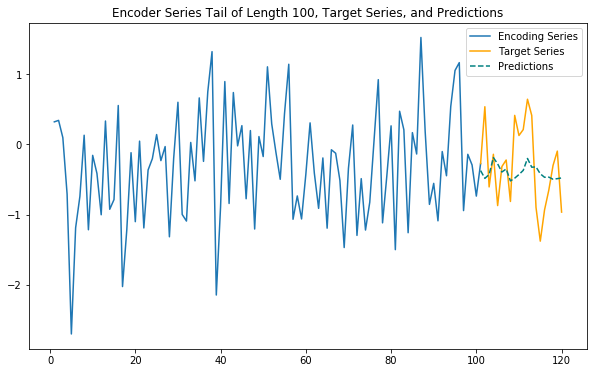

In [47]:
predict_and_plot(val_batch[0], val_batch[1], inf_batch[1],electrode=electrode, sample_ix=0, pred_steps=20)

In [48]:
def get_corr_mae(encoder_input_data, decoder_target_data, inf_target,
                 sample_ix, electrode: int,
                 pred_steps: int,
                 enc_tail_len=100, verbose=True):
    encode_series = encoder_input_data[sample_ix:sample_ix+1,:,:] 
    history_sequence_target = inf_target[sample_ix, :, :]
    pred_series = predict_sequence_m2o(encode_series,
                                       history_sequence_target,
                                       pred_steps,
                                       electrode,
                                       model)
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ix,:,:1].reshape(-1,1)
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    r, p = pearsonr(pred_series.reshape(-1), target_series.reshape(-1))
    mae = np.mean(np.abs(pred_series.reshape(-1) - target_series.reshape(-1)))
    if verbose:
        print(f"Correlation: {r}. P: {p}. MAE: {mae}")
    return r, mae

In [49]:
encoder_input_data = val_batch[0]
encoder_target_data = val_batch[1]

In [52]:
n_rows = int(encoder_input_data.shape[0]//2)
r_array = np.empty(shape=(n_rows,))
sample_maes = np.empty(shape=(n_rows,))
for sample_ix in range(n_rows):
    print(f"Sample: {sample_ix}/{n_rows}", end="\r")
    r, mae = get_corr_mae(encoder_input_data, encoder_target_data,
                          inf_batch[1],
                          sample_ix=sample_ix, electrode=electrode,
                          pred_steps=20, verbose=False)
    r_array[sample_ix] = r
    sample_maes[sample_ix] = mae
z_mean = np.mean(r_array)
batch_r = np.tanh(z_mean)
batch_mae = np.mean(sample_maes)
print(f"Batch_r: {batch_r}")
print(f"Batch Mae: {batch_mae}")

Batch_r: -0.042060765819039045
Batch Mae: 0.5368205013840035


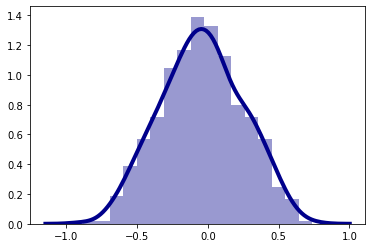

In [53]:
# Plot the distribution of r
import seaborn as sns
sns.distplot(r_array, kde=True, color = 'darkblue',
             kde_kws={'linewidth': 4})

In [54]:
k = 5
top_k_r = np.abs(r_array).argsort()[:k]
print(top_k_r)

[376 165 394 125 296]


Correlation: 0.0012676755417255076. P: 0.995767920788275. Mae: 0.5377796350137627
Correlation: 0.0018716979676778114. P: 0.9937514500008915. Mae: 0.457452142895001
Correlation: 0.0033111964478935094. P: 0.9889459916671947. Mae: 0.35397020156332976
Correlation: -0.004215792235113678. P: 0.9859263691800202. Mae: 0.5486351555439037
Correlation: -0.006165221602701436. P: 0.9794196758705322. Mae: 0.47037119418043805


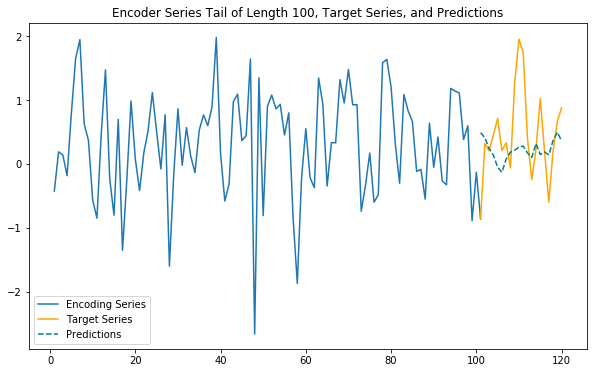

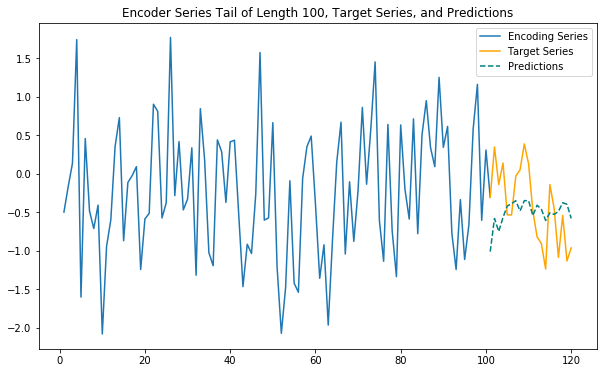

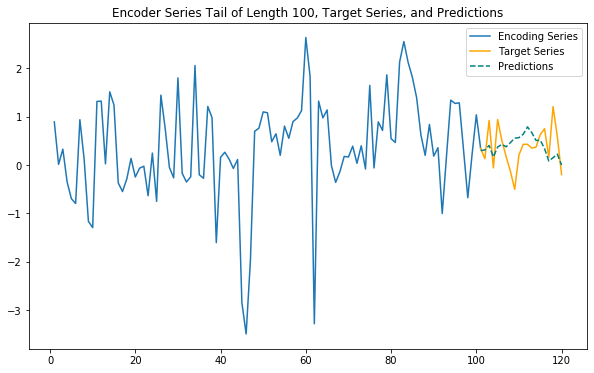

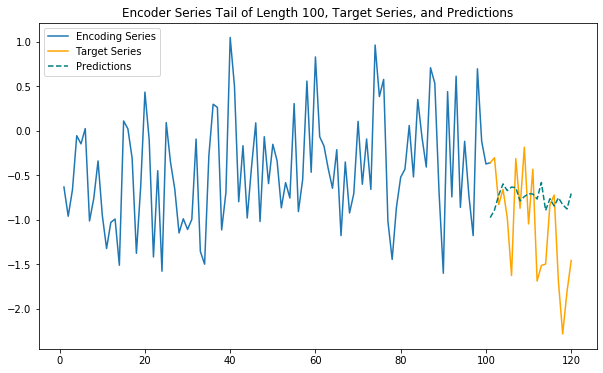

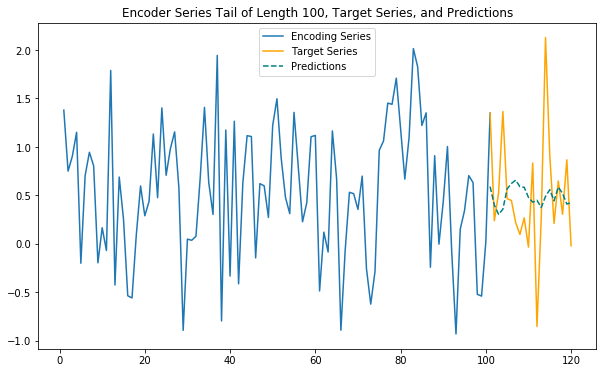

In [55]:
for i in top_k_r:
    predict_and_plot(val_batch[0], val_batch[1], inf_batch[1], sample_ix=i, electrode=electrode,
                     pred_steps=20)

In [56]:
k = 5
top_k_mae = sample_maes.argsort()[:k]
print(top_k_mae)

[110 188 155 212 477]


Correlation: 0.3517974640155538. P: 0.1282373347781245. Mae: 0.2749432275008683
Correlation: -0.36614179576164757. P: 0.11235157738088482. Mae: 0.27691558609067557
Correlation: 0.4269112260326381. P: 0.06048041650165883. Mae: 0.3074334996306252
Correlation: 0.04029150973314852. P: 0.8660683179545154. Mae: 0.3079420749573546
Correlation: -0.2269213906022656. P: 0.3359942688169442. Mae: 0.3097679042651992


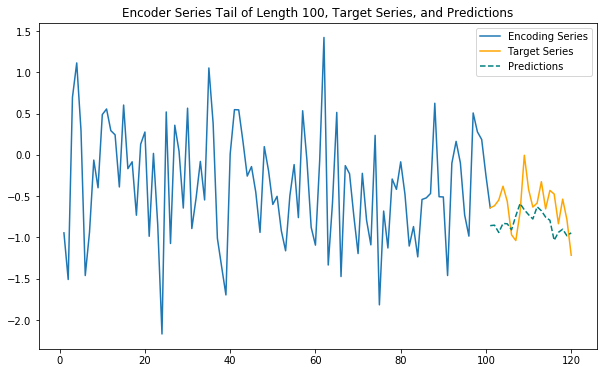

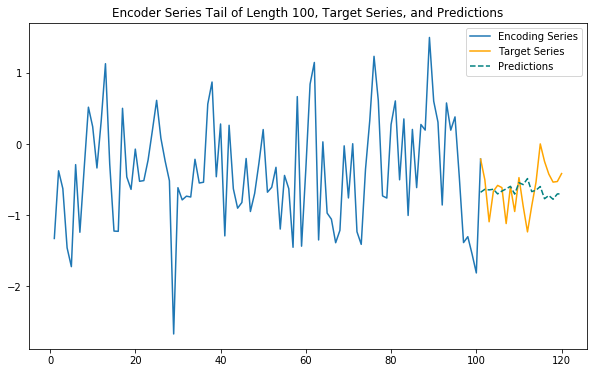

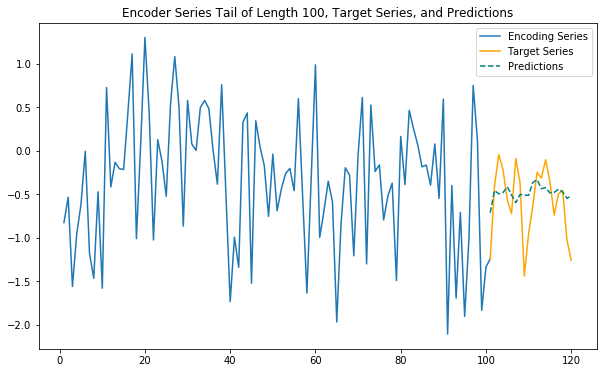

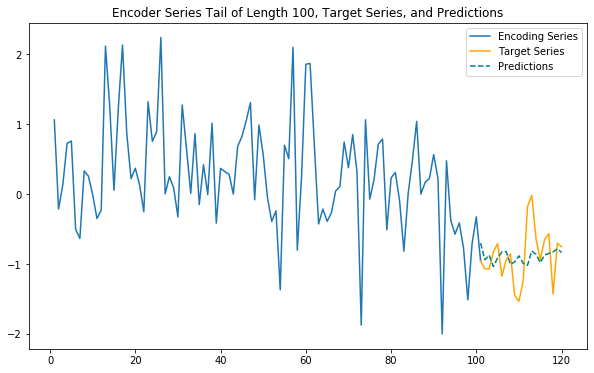

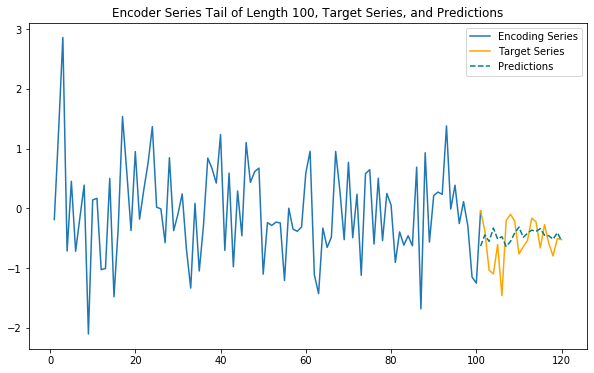

In [57]:
for i in top_k_mae:
    predict_and_plot(val_batch[0], val_batch[1], inf_batch[1], sample_ix=i, electrode=electrode,
                     pred_steps=20)

In [58]:


def predict_sequence_m2o_window(input_sequence,
                                history_sequence_target,
                                pred_steps,
                                target_electrode,
                                electrodes,
                                model=model,
                                lookback=lookback):
    electrode_count = len(electrodes)
    pred_sequence = np.zeros((pred_steps,)) # initialize output (pred_steps time steps)  
    history_sequence = input_sequence
    history_sequence_target = np.array([history_sequence_target])

#     print(history_sequence.shape)

    for i in range(pred_steps):
        # record next time step prediction (last time step of model output) 
        history_sequence = history_sequence.reshape((1, lookback, len(electrodes)))
#         print(history_sequence.shape)
        last_step_pred = model.predict(history_sequence)
#         last_step_pred = last_step_pred.reshape(-1)
        
        pred_sequence[i] = last_step_pred[:, -1, :]
#         print(pred_sequence.shape)
        history_sequence_target[0, i, electrode] = pred_sequence[i]
#         print(history_sequence_target.shape)
#         print(history_sequence_target[:, i, electrode].shape)
#         print(history_sequence_target[:, i, :].shape)
        
        # add the next time step prediction to the history sequence
        history_sequence = np.concatenate([history_sequence[:, -(lookback-1):, :], 
                                           history_sequence_target[:, i, :].reshape(1, 1, electrode_count)], axis=1)
#     print(len(pred_sequence))
    return pred_sequence

def moving_window_pred_m2o(input_sequence,
                           lookback,
                           pred_steps,
                           electrode_count,
                           electrodes,
                           target_electrode,
                           model):
    # for each window of lookback predict steps and then
    # move window up by pred steps and repeat
    # window = input_sequence[w_start: w_end]
    final_array = np.empty(shape=(input_sequence.shape[0], 1))
    print(final_array.shape)
    w_start = 0
    w_end = w_start + lookback
    final_array[w_start : w_end] = input_sequence[w_start : w_end, target_electrode].reshape(lookback, 1)
    history_sequence_target = input_sequence
    while w_end + pred_steps < input_sequence.shape[0]:
        window_lookback = input_sequence[w_start: w_end, electrodes]
        pred_seq = predict_sequence_m2o_window(window_lookback,
                                               history_sequence_target,
                                               pred_steps,
                                               target_electrode = target_electrode,
                                               electrodes = electrodes,
                                               model=model,
                                               lookback=lookback)
#         print(pred_seq.shape)
        final_array[w_end:w_end+pred_steps] = pred_seq.reshape(pred_steps, 1)
        w_start += pred_steps
        w_end += pred_steps
    return final_array

def get_corr_mae_conv(input_seq,
                      lookback,
                      pred_length,
                      electrode_count,
                      electrodes,
                      target_electrode,
                      model,
                      enc_tail_len=100,
                      verbose=True):
    
    
    print(input_seq.shape)
    input_seq = input_seq[:,[*electrodes]].reshape(input_seq.shape[0], electrode_count)

    predicted_series = moving_window_pred_m2o(input_seq,
                                              lookback = lookback,
                                              pred_steps = pred_length,
                                              target_electrode=target_electrode,
                                              electrodes = electrodes,
                                              electrode_count=electrode_count,
                                              model=model)
    
    input_seq = input_seq[lookback:, target_electrode]
    print(input_seq.shape)
    predicted_series = predicted_series[lookback:,:]

    input_series = input_seq.reshape(-1,1)
    pred_series = predicted_series.reshape(-1,1)   
    
    x_encode = input_series.shape[0]
    print(input_series.shape)
    print(pred_series.shape)
    r, p = pearsonr(pred_series.reshape(-1), input_series.reshape(-1))
    mae = np.mean(np.abs(pred_series.reshape(-1) - input_series.reshape(-1)))
    if verbose:
        print(f"Correlation: {r}. P: {p}. MAE: {mae}")
    plt.figure(figsize=(10,6))   
    plt.plot(range(x_encode),input_series)
    plt.plot(range(x_encode),pred_series,color='orange',linestyle='--')
    plt.legend(['Input Series', 'Predictions'])
    return r, mae

In [22]:
data = np.load(val_paths[0])

In [23]:
target_electrode = electrode

In [24]:
target_electrode

5

(1100, 114)
(1100, 1)
(1000,)
(1000, 1)
(1000, 1)
Correlation: 0.45176453042711934. P: 1.890030469391733e-51. MAE: 0.609933641952705


(0.45176453042711934, 0.609933641952705)

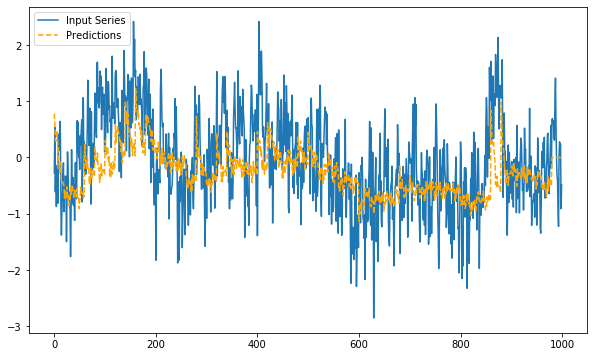

In [14]:
get_corr_mae_conv(data[:1100,:],
                  lookback,
                  pred_length, electrode_count=len(electrodes),
                  electrodes=electrodes,
                  target_electrode=target_electrode,
                  model=model)

In [25]:
def get_corr_mae_conv_step(input_seq,
                      lookback,
                      pred_length,
                      k,
                      electrode_count,
                      electrodes,
                      target_electrode,
                      model,
                      enc_tail_len=100,
                      verbose=True):
    
    
    print(input_seq.shape)
    input_seq = input_seq[:,[*electrodes]].reshape(input_seq.shape[0], electrode_count)

    predicted_series = moving_window_pred_m2o_step(input_seq,
                                                   lookback = lookback,
                                                   pred_steps = pred_length,
                                                   k=k,
                                                   target_electrode=target_electrode,
                                                   electrodes = electrodes,
                                                   electrode_count=electrode_count,
                                                   model=model)
    
    input_seq = input_seq[lookback + k:, target_electrode]
    print(input_seq.shape)

    input_series = input_seq.reshape(-1,1)
    predicted_series = predicted_series[lookback + k:,target_electrode]
    pred_series = predicted_series.reshape(-1,1)   
    
    x_encode = input_series.shape[0]
    print(input_series.shape)
    print(pred_series.shape)
    r, p = pearsonr(pred_series.reshape(-1), input_series.reshape(-1))
    mae = np.mean(np.abs(pred_series.reshape(-1) - input_series.reshape(-1)))
    if verbose:
        print(f"Correlation: {r}. P: {p}. MAE: {mae}")
    plt.figure(figsize=(10,6))   
    plt.plot(range(x_encode),input_series)
    plt.plot(range(x_encode),pred_series,color='orange',linestyle='--')
    plt.legend(['Input Series', 'Predictions'])
    return r, mae

def moving_window_pred_m2o_step(input_sequence,
                                lookback,
                                pred_steps,
                                k,
                                target_electrode,
                                electrodes,
                                electrode_count,
                                model):
    # for each window of lookback predict steps and then
    # move window up by pred steps and repeat
    # window = input_sequence[w_start: w_end]
    
    electrode_count = len(electrodes)
    final_array = np.empty(shape=(input_sequence.shape[0], electrode_count))
    
    w_start = 0
    w_end = w_start + lookback
    final_array[w_start : w_end + k, :] = input_sequence[w_start : w_end + k, :]
    print(final_array.shape)
    full_length = int(len(input_sequence))
    print(full_length)
    i = w_end + k
    while i < full_length:
        window_lookback = np.array([input_sequence[w_start: w_end, [*electrodes]]])
#         print(window_lookback.shape)
        pred_steps = model.predict(window_lookback)
#         print(pred_steps.reshape((20, 1)))
#         print(pred_steps.shape)
        final_array[w_end + k] = pred_steps[:,k,:].reshape((1, 1))
        w_end += 1
        w_start += 1
        i += 1
    return final_array

(1100, 114)
(1100, 114)
1100
(1000,)
(1000, 1)
(1000, 1)
Correlation: 0.3780469154765683. P: 2.511578490806949e-35. MAE: 0.6413543345569963


(0.3780469154765683, 0.6413543345569963)

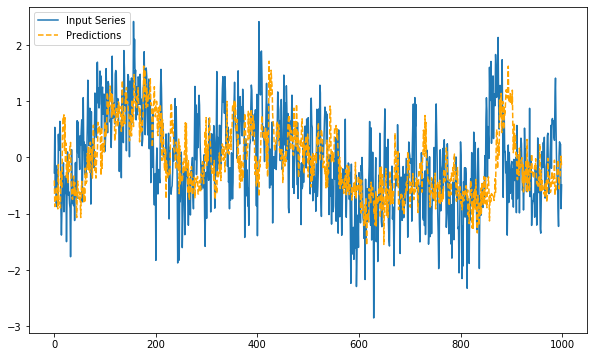

In [16]:
get_corr_mae_conv_step(data[:1100,:],
                  lookback,
                  pred_length, 0,electrode_count=len(electrodes),
                  electrodes=electrodes,
                  target_electrode=target_electrode,
                  model=model)

(1100, 114)
(1100, 114)
1100
(995,)
(995, 1)
(995, 1)
Correlation: 0.3788216920550044. P: 2.630346986511845e-35. MAE: 0.6420109542224257


(0.3788216920550044, 0.6420109542224257)

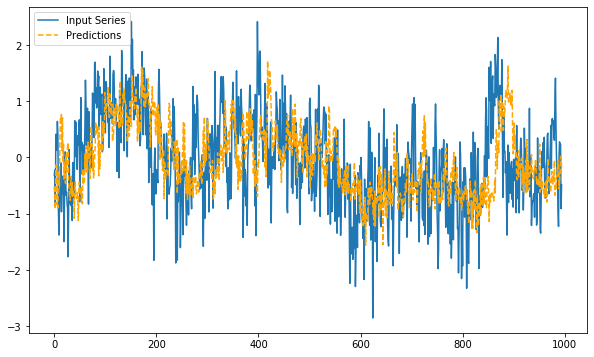

In [17]:
get_corr_mae_conv_step(data[:1100,:],
                  lookback,
                  pred_length, 5,electrode_count=len(electrodes),
                  electrodes=electrodes,
                  target_electrode=target_electrode,
                  model=model)

TEST DATA

# TEST DATA

In [26]:
test_paths = utils.get_file_paths("/home/tmarcu/brain2brain/brain2brain/test_676_bin_norm_2.txt")

In [27]:
test_paths[0]

'/projects/HASSON/247/data/binned_conversations/676_bin_norm_2/bin_norm_2_NY676_618_Part5-one_conversation1/bin_norm_2_NY676_618_Part5-one_conversation1.npy'

In [28]:
for path in test_paths:
    utils.get_file_shape(path)

(163846, 114)
(102096, 114)
(73475, 114)
(33158, 114)
(17795, 114)
(64950, 114)
(92170, 114)
(83951, 114)
(42936, 114)
(21311, 114)


In [59]:
test_data2 = np.load(test_paths[1])

(1100, 114)
(1100, 1)
(1000,)
(1000, 1)
(1000, 1)
Correlation: 0.3983065707653275. P: 2.310101268136351e-39. MAE: 0.8245015262581258


(0.3983065707653275, 0.8245015262581258)

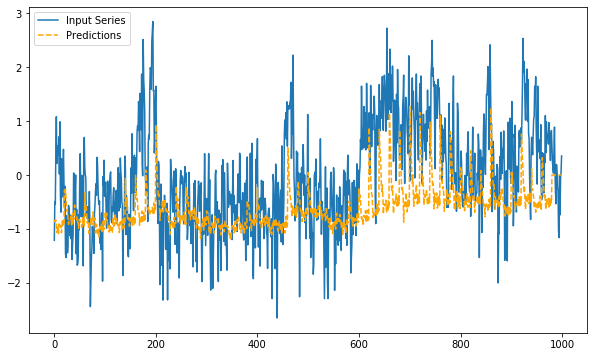

In [61]:
get_corr_mae_conv(test_data2[:1100,:],
                  lookback,
                  pred_length, electrode_count=len(electrodes),
                  electrodes=electrodes,
                  target_electrode=target_electrode,
                  model=model)

In [29]:
test_data = np.load(test_paths[0])

(1100, 114)
(1100, 1)
(1000,)
(1000, 1)
(1000, 1)
Correlation: 0.25832158428656327. P: 1.0419958245039133e-16. MAE: 0.6840802865851197


(0.25832158428656327, 0.6840802865851197)

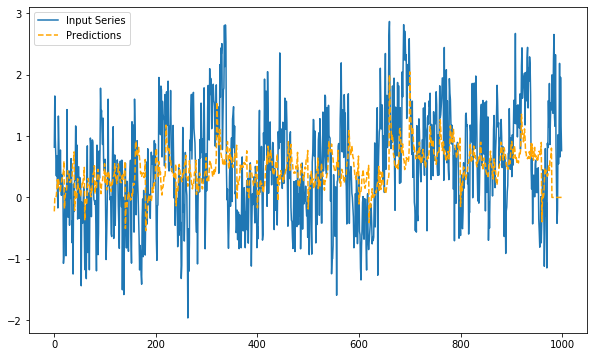

In [32]:
get_corr_mae_conv(test_data[300:1400,:],
                  lookback,
                  pred_length, electrode_count=len(electrodes),
                  electrodes=electrodes,
                  target_electrode=target_electrode,
                  model=model)

(350, 114)
(350, 1)
(250,)
(250, 1)
(250, 1)
Correlation: 0.23771651222740345. P: 0.0001480458839169156. MAE: 0.6862982383436043


(0.23771651222740345, 0.6862982383436043)

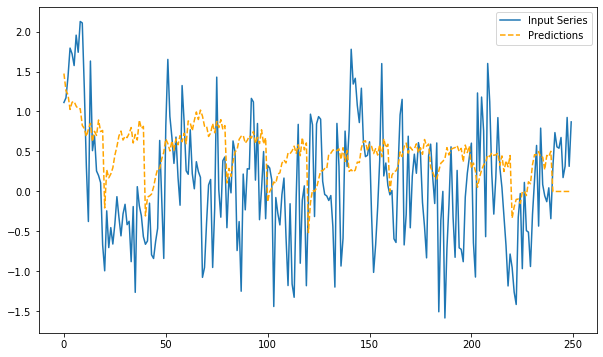

In [33]:
get_corr_mae_conv(test_data[250:600,:],
                  lookback,
                  pred_length, electrode_count=len(electrodes),
                  electrodes=electrodes,
                  target_electrode=target_electrode,
                  model=model)

(1100, 114)
(1100, 1)
(1000,)
(1000, 1)
(1000, 1)
Correlation: 0.11338702689436742. P: 0.00032724397379009566. MAE: 0.7472101646199969


(0.11338702689436742, 0.7472101646199969)

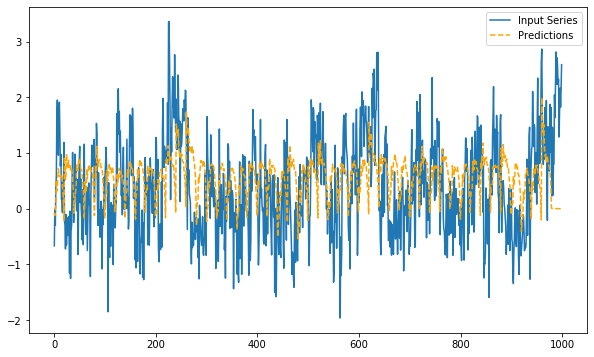

In [30]:
get_corr_mae_conv(test_data[:1100,:],
                  lookback,
                  pred_length, electrode_count=len(electrodes),
                  electrodes=electrodes,
                  target_electrode=target_electrode,
                  model=model)

(300, 114)
(300, 114)
300
(200,)
(200, 1)
(200, 1)
Correlation: -0.20448140103887158. P: 0.0036792257699685823. MAE: 0.7811809922284215


(-0.20448140103887158, 0.7811809922284215)

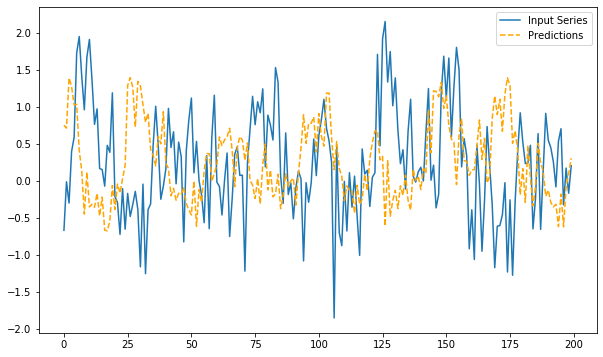

In [31]:
get_corr_mae_conv_step(test_data[:300,:],
                  lookback,
                  pred_length, 0,electrode_count=len(electrodes),
                  electrodes=electrodes,
                  target_electrode=target_electrode,
                  model=model)

(1100, 114)
(1100, 114)
1100
(1000,)
(1000, 1)
(1000, 1)
Correlation: 0.13089934293085997. P: 3.294370288708045e-05. MAE: 0.8039707489827032


(0.13089934293085997, 0.8039707489827032)

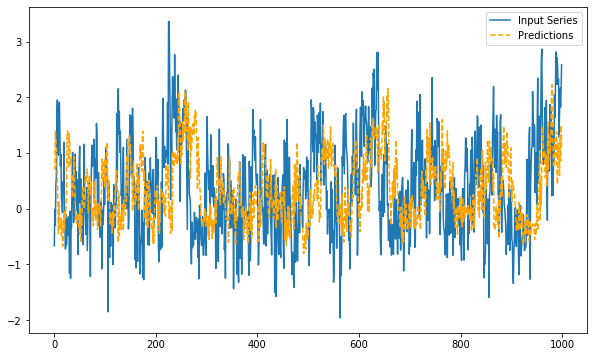

In [32]:
get_corr_mae_conv_step(test_data[:1100,:],
                  lookback,
                  pred_length, 0,electrode_count=len(electrodes),
                  electrodes=electrodes,
                  target_electrode=target_electrode,
                  model=model)

(1100, 114)
(1100, 114)
1100
(995,)
(995, 1)
(995, 1)
Correlation: 0.1337305093177898. P: 2.315558703942807e-05. MAE: 0.8029399907317133


(0.1337305093177898, 0.8029399907317133)

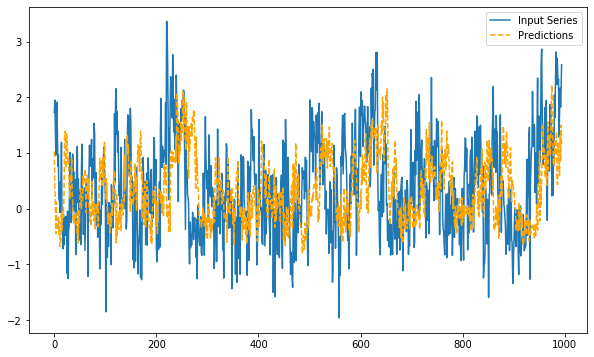

In [35]:
get_corr_mae_conv_step(test_data[:1100,:],
                  lookback,
                  pred_length, 5,electrode_count=len(electrodes),
                  electrodes=electrodes,
                  target_electrode=target_electrode,
                  model=model)

(1100, 114)
(1100, 114)
1100
(990,)
(990, 1)
(990, 1)
Correlation: 0.13449948964432928. P: 2.177300789895967e-05. MAE: 0.8003811580833085


(0.13449948964432928, 0.8003811580833085)

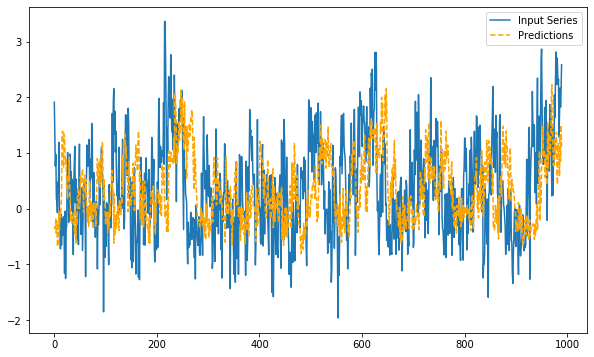

In [36]:
get_corr_mae_conv_step(test_data[:1100,:],
                  lookback,
                  pred_length, 10,electrode_count=len(electrodes),
                  electrodes=electrodes,
                  target_electrode=target_electrode,
                  model=model)

In [24]:
# Test_gene
test_generator = generators.FGenerator(file_paths=test_paths,
                                        lookback=lookback,
                                        length=pred_length,
                                        delay=0,
                                        batch_size=2048,
                                        sample_period=1,
                                        electrodes=electrodes,
                                        electrode_output_ix=target_electrode,
                                        shuffle=False)

In [25]:
len(test_generator)

2

In [26]:
test_batch = test_generator[0]

In [27]:
encoder_input_data = test_batch[0]
encoder_target_data = test_batch[1]

In [34]:
n_rows = int(encoder_input_data.shape[0]//2)
r_array = np.empty(shape=(n_rows,))
sample_maes = np.empty(shape=(n_rows,))
for sample_ix in range(n_rows):
    print(f"Sample: {sample_ix}/{n_rows}", end="\r")
    r, mae = get_corr_mae(encoder_input_data, encoder_target_data,
                          inf_batch[1],
                          sample_ix=sample_ix, electrode=electrode,
                          pred_steps=20, verbose=False)
    r_array[sample_ix] = r
    sample_maes[sample_ix] = mae
z_mean = np.mean(r_array)
batch_r = np.tanh(z_mean)
batch_mae = np.mean(sample_maes)
print(f"Batch_r: {batch_r}")
print(f"Batch Mae: {batch_mae}")

Batch_r: 0.07390052069036486
Batch Mae: 0.6917688861213863
